In [2]:
import sys
import torch

In [3]:
sys.path.append('../')

In [4]:
from vt_captioning.vt_resnet import vt_resnet50

In [5]:
feature_extractor = vt_resnet50(
            pretrained=True,
            freeze='full_freeze',
            tokens=16,
            token_channels=128,
            input_dim=1024,
            vt_channels=2048,
            transformer_enc_layers=2,
            transformer_heads=8,
            transformer_fc_dim=2048,
            image_channels=3,
        ).to('cuda')

In [6]:
from transformers import AutoTokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [8]:
VOCAB_SIZE = len(tokenizer)

In [9]:
from transformer_code.vt_captioning import VTCaptionModel

In [10]:
model = VTCaptionModel(feature_extractor, num_layers = 4, d_model = 512, num_heads = 8, dff = 2048, row_size = 1, col_size = 1, target_vocab_size = VOCAB_SIZE, max_pos_encoding=VOCAB_SIZE, rate=0.2).to('cuda')

In [11]:
model.load_state_dict(torch.load('../VTResCaptioner.pt'))

<All keys matched successfully>

In [111]:
import pandas as pd


In [112]:
dataset = pd.read_csv('../test.csv')

In [113]:
dataset = pd.read_csv('../train.csv')

In [243]:
test_image = dataset.image_file[16740]

In [244]:
from PIL import Image

In [245]:
test_image = Image.open('../' + test_image)

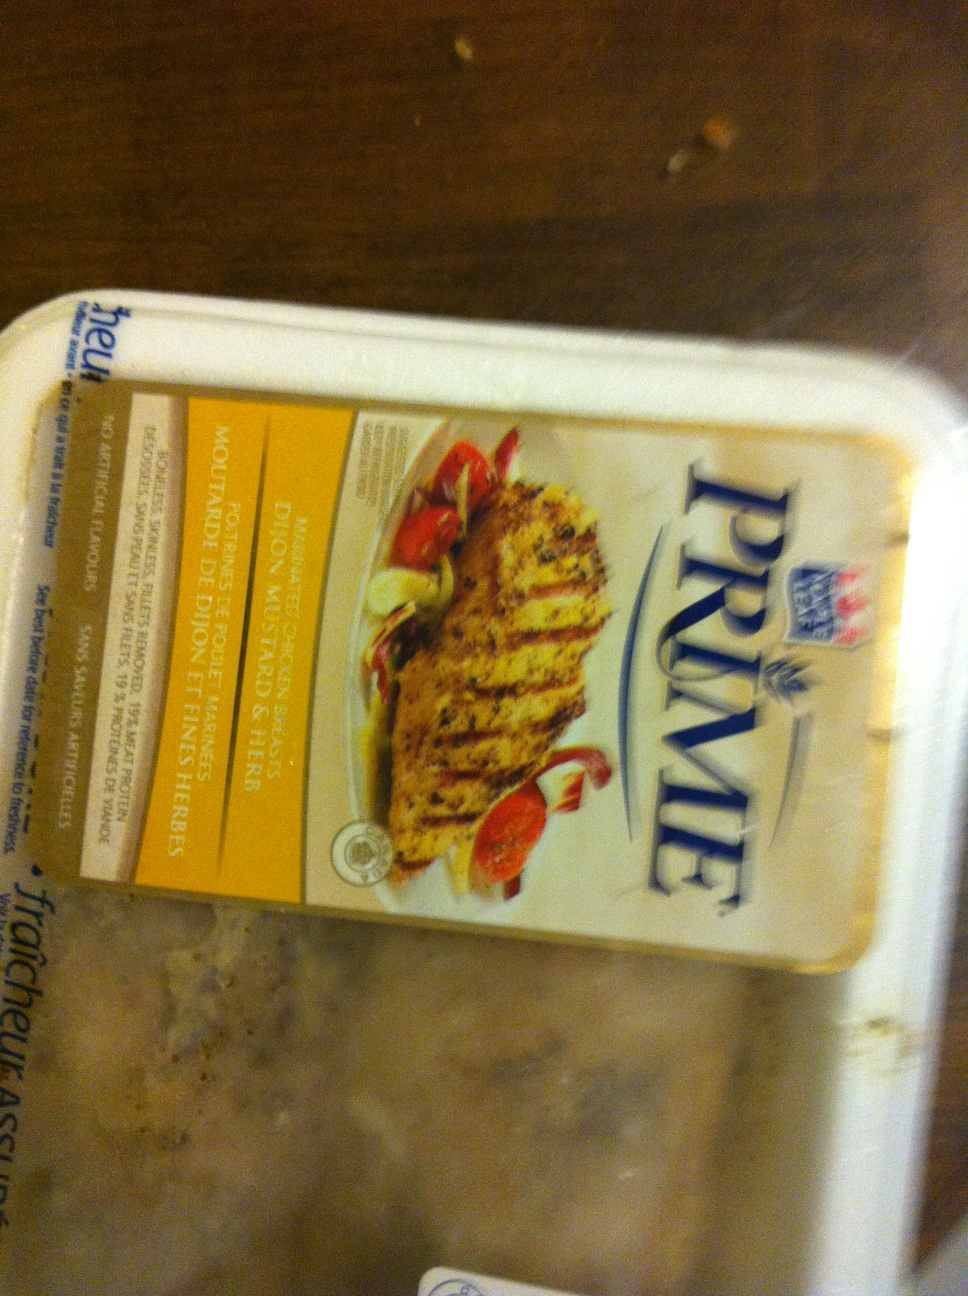

In [246]:
test_image

In [247]:
import torchvision

In [248]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize((300, 300)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [249]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [250]:
from transformer_code.mha import create_look_ahead_mask, create_padding_mask

def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tar.size(1)).to('cuda')
    dec_target_padding_mask = create_padding_mask(tar)

    combined_mask = torch.max(dec_target_padding_mask.unsqueeze(1), look_ahead_mask)
    return combined_mask

In [251]:
decoder_input.size()

torch.Size([129, 1])

In [252]:
import torch

def evaluate(image):

    input = transform(image).unsqueeze(0).to("cuda") 

    decoder_input = ["[CLS]"] + ["[PAD]"] * 128
    
    decoder_input = tokenizer(decoder_input, add_special_tokens = False, return_tensors="pt")["input_ids"].to("cuda").permute(1,0)

    result = []  # Word list

    for i in range(128):
        with torch.no_grad():
            dec_mask = create_masks_decoder(decoder_input).to("cuda")
            predictions, _ = model(input, decoder_input, dec_mask)

            predicted_id = torch.argmax(predictions.permute(0,2,1), dim=-1)[0][i].to(torch.int32)
            if tokenizer.decode(predicted_id) == "[SEP]" or tokenizer.decode(predicted_id) == "[PAD]":
                return result

            result.append(tokenizer.decode(predicted_id))
        
            decoder_input[0, i+1] = predicted_id

    return result

In [259]:
evaluate(test_image)

['a', 'wooden', 'table', '##cloth']